# Fake New Dectection_Dataset4

In [1]:
import numpy as np
import pandas as pd
import re,string,unicodedata
import os

# NLP Libs
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
#from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#ML Algos
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score,
                             roc_auc_score)

In [2]:
# Import our data
df= pd.read_csv("./dataset/liar_dataset/train.tsv", sep='\t')

# Data Analysis

In [3]:
df['status'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [4]:
def label_assignment(text):
    if text=='half-true' or text=='mostly-true' or text=='true':
        return 0
    else:
        return 1

In [5]:
#Create new column label Assignment 0 to column values: true, half-true, mostly-true
#Create new column label Assignment 1 to column values: false, barely-true, pants-fire

df['label'] = df['status'].apply(label_assignment)

In [6]:
df.head()

,ID,status,statement,subject,speaker,job_title,state_info,party_affiliation,btc,fc,htc,mtc,pfc,context,label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0


In [7]:
df.columns

Index(['ID', 'status', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'btc', 'fc', 'htc', 'mtc', 'pfc',
       'context', 'label'],
      dtype='object')

In [8]:
# Droping unnecessary columns
colums_to_drop = ['ID', 'status', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'btc', 'fc', 'htc', 'mtc', 'pfc',
       'context']

df = df.drop(colums_to_drop, axis = 1)

In [9]:
df.head()

,statement,subject,label
0,Says the Annies List political group supports ...,abortion,1
1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",0
2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,0
3,Health care reform legislation is likely to ma...,health-care,1
4,The economic turnaround started at the end of ...,"economy,jobs",0


In [10]:
df=df.fillna(' ')
# Now we'll create the Corpus that will be used in our NLP model

# This will create a single column with all the relevant text

df['total']=df['subject']+' '+df['statement']

In [11]:
df = df.drop(['statement', 'subject'], axis = 1)

In [12]:
print(df.isnull().sum())

label    0
total    0
dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10240 non-null  int64 
 1   total   10240 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.1+ KB


In [14]:
df.shape

(10240, 2)

In [15]:
df['label'].value_counts()

0    5752
1    4488
Name: label, dtype: int64

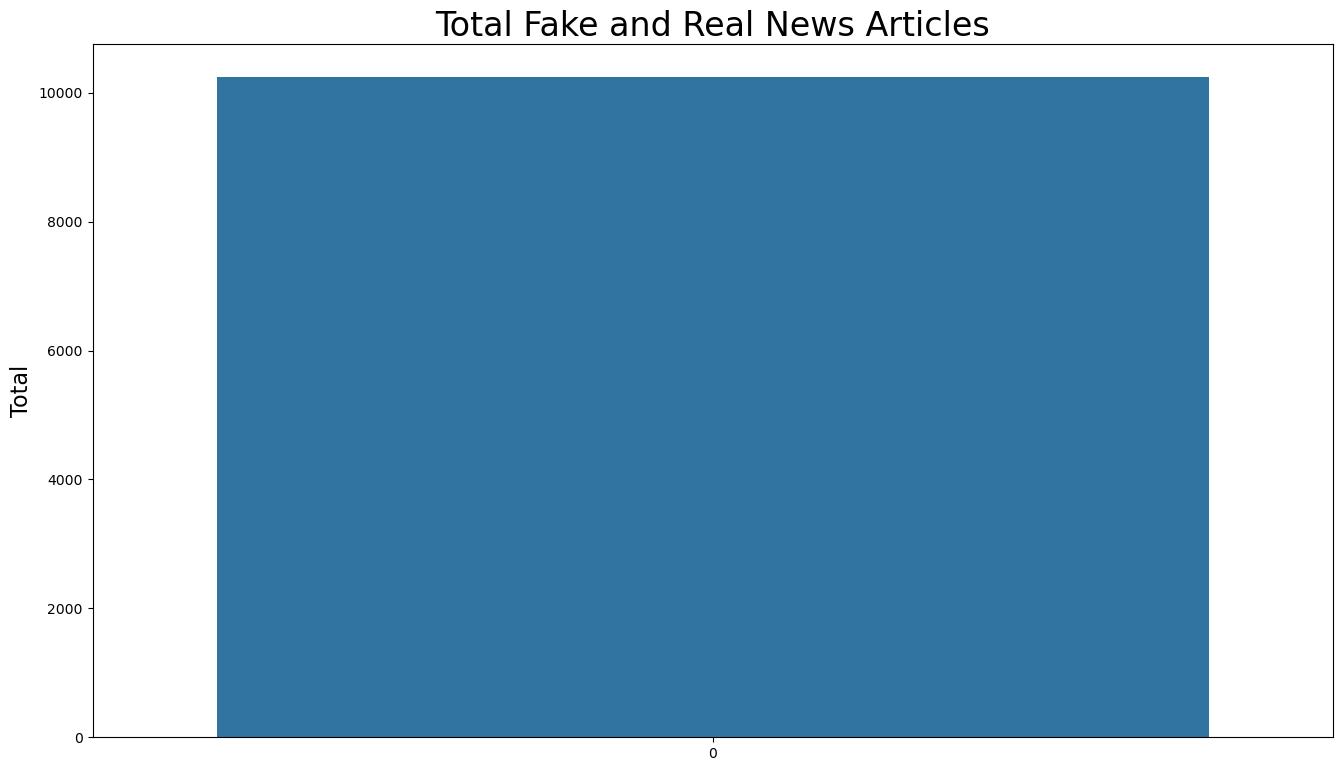

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))

sns.countplot(df['label'])
plt.title('Total Fake and Real News Articles', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
#plt.xticks([1, 0], ['Fake', 'Real'], fontsize=16)

plt.show()

In [17]:
df.head()

,label,total
0,1,abortion Says the Annies List political group ...
1,0,"energy,history,job-accomplishments When did th..."
2,0,foreign-policy Hillary Clinton agrees with Joh...
3,1,health-care Health care reform legislation is ...
4,0,"economy,jobs The economic turnaround started a..."


# Cleaning and preprocessing

In [18]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [19]:
stop_words = stopwords.words('english')
lemmatizer=WordNetLemmatizer()
for index,row in df.iterrows():
    filter_sentence = ''

    sentence = row['total']
    sentence = re.sub(r'[^\w\s]','',sentence) #cleaning
    words = nltk.word_tokenize(sentence) #tokenization
    words = [w.lower() for w in words if not w in stop_words]  #stopwords removal

    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()

    df.loc[index,'total'] = filter_sentence

In [20]:
# from sklearn.utils import shuffle

# df = shuffle(df, random_state=42)
# df.head()

In [21]:
df.to_csv("./dataset/liar_dataset/cleaned_dataset.csv")

# Vectorization

In [22]:
X_train = df['total']
Y_train = df['label']

In [23]:
#Feature extraction using count vectorization and tfidf.
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)
freq_term_matrix = count_vectorizer.transform(X_train)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [24]:
tf_idf_matrix

<10240x15593 sparse matrix of type '<class 'numpy.float64'>'
	with 121406 stored elements in Compressed Sparse Row format>

# Modeling

In [25]:
test_counts = count_vectorizer.transform(df['total'].values)
test_tfidf = tfidf.transform(test_counts)

#split in samples
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state=0)


from sklearn.model_selection import StratifiedShuffleSplit

# Sample data (replace this with your dataset)
X = tf_idf_matrix  # Features
y = Y_train    # Target labels (0 or 1)

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Now, X_train and y_train contain the training data and labels, and X_test and y_test contain the test data and labelss

In [26]:
print(X_train.shape, X_test.shape)

(8192, 15593) (2048, 15593)


In [27]:
print(y_train.shape, y_test.shape)

(8192,) (2048,)


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Training and Evaluation

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Model Precison:  0.504524886877828
Model Recall Score:  0.49665924276169265
Model F1 Score:  0.5005611672278338
Model Accuracy Score:  0.5654296875
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1150
           1       0.50      0.50      0.50       898

    accuracy                           0.57      2048
   macro avg       0.56      0.56      0.56      2048
weighted avg       0.56      0.57      0.57      2048



C:\Users\Dac\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


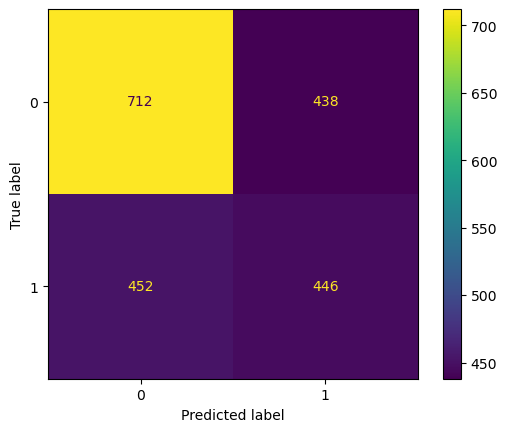

In [29]:
# DEMO
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
print('Accuracy of Logistic classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('====================================')
print('Model Precison: ', precision_score(y_test, pred))
print('Model Recall Score: ', recall_score(y_test, pred))
print('Model F1 Score: ', f1_score(y_test, pred))
print('Model Accuracy Score: ', accuracy_score(y_test, pred))
print('====================================')
print('classification_report: ')
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
cm
ConfusionMatrixDisplay.from_predictions(y_test,pred)


In [30]:
def get_evaluation_result(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    mcc = matthews_corrcoef(y_test, pred)
    kappa = cohen_kappa_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('Accuracy of Logistic classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
    print('Accuracy of Logistic classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    print('====================================')
    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Matthews Correlation Coefficient: {mcc}")
    print(f"Cohen's Kappa: {kappa}")
    print(f"AUC-ROC: {roc_auc}")
    print('====================================')
    print('classification_report: ')
    print(classification_report(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    cm
    ConfusionMatrixDisplay.from_predictions(y_test,pred)

# 1. “lbfgs” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60888671875
Precision: 0.5763779527559055
Recall: 0.40757238307349664
F1 Score: 0.4774951076320939
Matthews Correlation Coefficient: 0.18630619237925583
Cohen's Kappa: 0.17941658446399522
AUC-ROC: 0.586829669797618
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1150
           1       0.58      0.41      0.48       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.60      2048



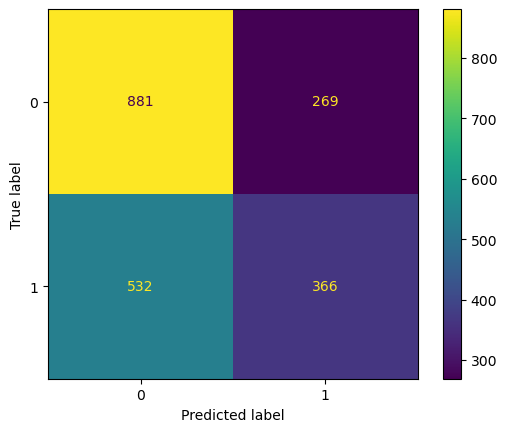

In [31]:
from sklearn.linear_model import LogisticRegression
lbfgs = LogisticRegression(solver='lbfgs')

get_evaluation_result(lbfgs, X_train, X_test, y_train, y_test)

# 2. “liblinear” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60888671875
Precision: 0.5763779527559055
Recall: 0.40757238307349664
F1 Score: 0.4774951076320939
Matthews Correlation Coefficient: 0.18630619237925583
Cohen's Kappa: 0.17941658446399522
AUC-ROC: 0.586829669797618
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1150
           1       0.58      0.41      0.48       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.60      2048



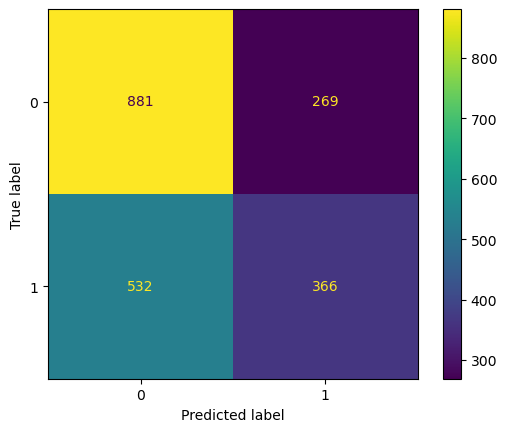

In [32]:
liblinear = LogisticRegression(solver='liblinear')

get_evaluation_result(liblinear, X_train, X_test, y_train, y_test)

# 3. “newton-cg” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.6083984375
Precision: 0.5757097791798107
Recall: 0.4064587973273942
F1 Score: 0.4765013054830287
Matthews Correlation Coefficient: 0.18519191863679682
Cohen's Kappa: 0.17828855474487615
AUC-ROC: 0.5862728769245668
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1150
           1       0.58      0.41      0.48       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.59      2048



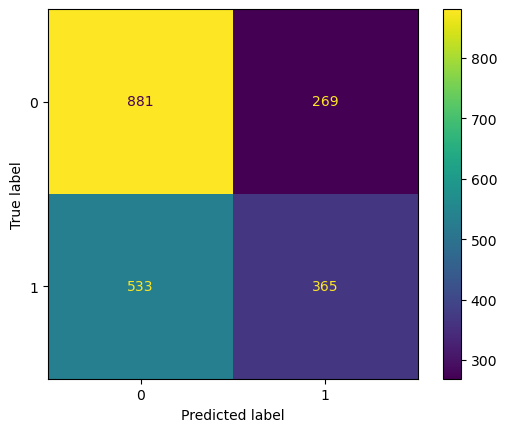

In [33]:
newton_cg = LogisticRegression(solver='newton-cg')

get_evaluation_result(newton_cg, X_train, X_test, y_train, y_test)

# 4. “sag” Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.6083984375
Precision: 0.5757097791798107
Recall: 0.4064587973273942
F1 Score: 0.4765013054830287
Matthews Correlation Coefficient: 0.18519191863679682
Cohen's Kappa: 0.17828855474487615
AUC-ROC: 0.5862728769245668
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1150
           1       0.58      0.41      0.48       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.59      2048



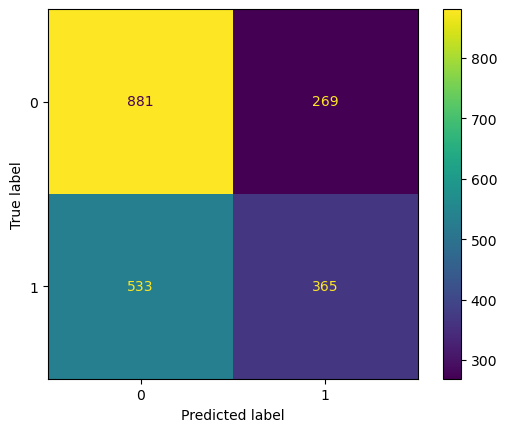

In [34]:
sag = LogisticRegression(solver='sag')

get_evaluation_result(sag, X_train, X_test, y_train, y_test)

# 5. Random Forest Logistic Regression

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.6044921875
Precision: 0.5805860805860806
Recall: 0.3530066815144766
F1 Score: 0.4390581717451524
Matthews Correlation Coefficient: 0.17267417332559398
Cohen's Kappa: 0.16078142516603466
AUC-ROC: 0.576938123365934
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.80      0.69      1150
           1       0.58      0.35      0.44       898

    accuracy                           0.60      2048
   macro avg       0.60      0.58      0.57      2048
weighted avg       0.60      0.60      0.58      2048



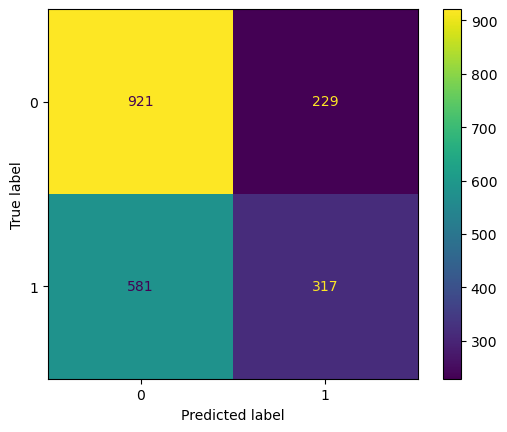

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

get_evaluation_result(rf, X_train, X_test, y_train, y_test)

# 6. Perceptron

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.57666015625
Precision: 0.5180863477246208
Recall: 0.49443207126948774
F1 Score: 0.505982905982906
Matthews Correlation Coefficient: 0.13609552531598318
Cohen's Kappa: 0.13598187505230974
AUC-ROC: 0.5676508182434394
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1150
           1       0.52      0.49      0.51       898

    accuracy                           0.58      2048
   macro avg       0.57      0.57      0.57      2048
weighted avg       0.57      0.58      0.58      2048



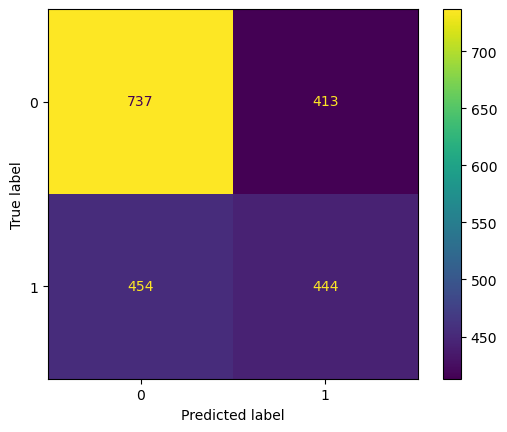

In [36]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=1000, eta0=0.1, random_state=0)
get_evaluation_result(perceptron, X_train, X_test, y_train, y_test)

# 7. RidgeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.59619140625
Precision: 0.5456885456885456
Recall: 0.47216035634743875
F1 Score: 0.5062686567164179
Matthews Correlation Coefficient: 0.1689366692935656
Cohen's Kappa: 0.16767932506039585
AUC-ROC: 0.5826019173041541
classification_report: 
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1150
           1       0.55      0.47      0.51       898

    accuracy                           0.60      2048
   macro avg       0.59      0.58      0.58      2048
weighted avg       0.59      0.60      0.59      2048



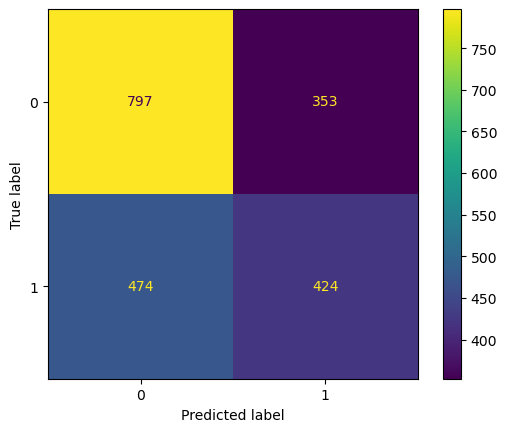

In [37]:
from sklearn.linear_model import RidgeClassifier
ridge_classifier = RidgeClassifier(alpha=1.0, solver='auto', random_state=0)
get_evaluation_result(ridge_classifier, X_train, X_test, y_train, y_test)

# 8. CatBoostClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.59375
Precision: 0.5816831683168316
Recall: 0.26169265033407574
F1 Score: 0.3609831029185868
Matthews Correlation Coefficient: 0.14306904930190958
Cohen's Kappa: 0.12209517999785668
AUC-ROC: 0.5573680642974727
classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.85      0.70      1150
           1       0.58      0.26      0.36       898

    accuracy                           0.59      2048
   macro avg       0.59      0.56      0.53      2048
weighted avg       0.59      0.59      0.55      2048



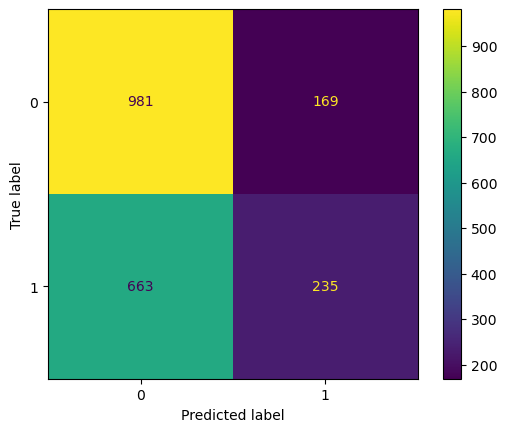

In [38]:
from catboost import CatBoostClassifier
# Create a CatBoostClassifier instance with specified hyperparameters
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=0)

get_evaluation_result(catboost_classifier, X_train, X_test, y_train, y_test)

# 9. NearestCentroidClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.58349609375
Precision: 0.5208140610545791
Recall: 0.6269487750556793
F1 Score: 0.5689742294087923
Matthews Correlation Coefficient: 0.17544465531390957
Cohen's Kappa: 0.17265888584315725
AUC-ROC: 0.5882569962234918
classification_report: 
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1150
           1       0.52      0.63      0.57       898

    accuracy                           0.58      2048
   macro avg       0.59      0.59      0.58      2048
weighted avg       0.60      0.58      0.58      2048



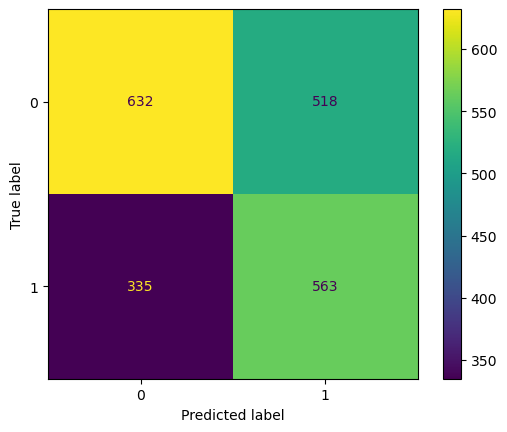

In [39]:
from sklearn.neighbors import NearestCentroid
ncc = NearestCentroid()

get_evaluation_result(ncc, X_train, X_test, y_train, y_test)

# 10. Stochastic Gradient Descent (SGDClassifier)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60498046875
Precision: 0.5610425240054869
Recall: 0.455456570155902
F1 Score: 0.5027658266748617
Matthews Correlation Coefficient: 0.18363442806681865
Cohen's Kappa: 0.18092635400620527
AUC-ROC: 0.5885978502953424
classification_report: 
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1150
           1       0.56      0.46      0.50       898

    accuracy                           0.60      2048
   macro avg       0.60      0.59      0.59      2048
weighted avg       0.60      0.60      0.60      2048



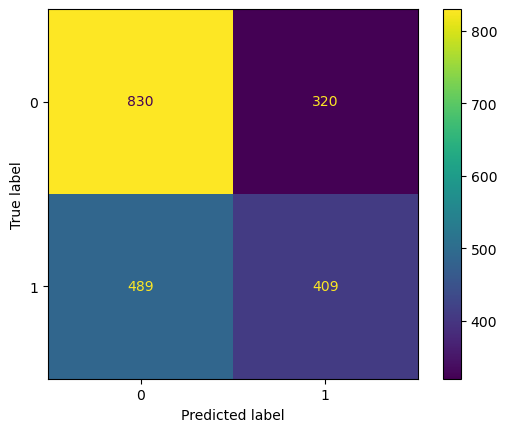

In [40]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier()

get_evaluation_result(sgd_classifier, X_train, X_test, y_train, y_test)

# 11. SVC (kernel=”linear”, C=0.025):

C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: 

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5615234375
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Cohen's Kappa: 0.0
AUC-ROC: 0.5
classification_report: 
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1150
           1       0.00      0.00      0.00       898

    accuracy                           0.56      2048
   macro avg       0.28      0.50      0.36      2048
weighted avg       0.32      0.56      0.40      2048



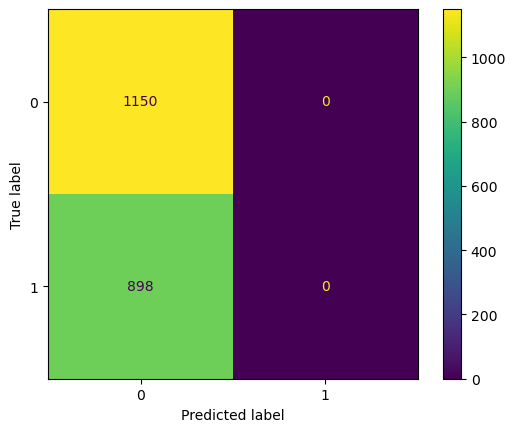

In [41]:
from sklearn.svm import SVC
svm_lin = SVC(kernel="linear", C=0.025)

get_evaluation_result(svm_lin, X_train, X_test, y_train, y_test)

# 12. SVC (gama=2, C=1)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60009765625
Precision: 0.6053333333333333
Recall: 0.25278396436525613
F1 Score: 0.35663786331500397
Matthews Correlation Coefficient: 0.15920414166524113
Cohen's Kappa: 0.1325462711082518
AUC-ROC: 0.5620441560956715
classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1150
           1       0.61      0.25      0.36       898

    accuracy                           0.60      2048
   macro avg       0.60      0.56      0.53      2048
weighted avg       0.60      0.60      0.55      2048



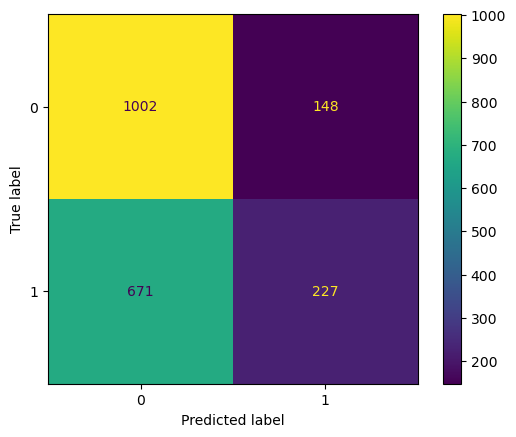

In [42]:
svm_rbf = SVC(kernel="rbf", gamma=2, C=1)

get_evaluation_result(svm_rbf, X_train, X_test, y_train, y_test)

# 13. LinearSVC

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5859375
Precision: 0.5306372549019608
Recall: 0.4821826280623608
F1 Score: 0.5052508751458576
Matthews Correlation Coefficient: 0.1511570188889335
Cohen's Kappa: 0.15064634260853238
AUC-ROC: 0.5745695749007456
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      1150
           1       0.53      0.48      0.51       898

    accuracy                           0.59      2048
   macro avg       0.58      0.57      0.57      2048
weighted avg       0.58      0.59      0.58      2048



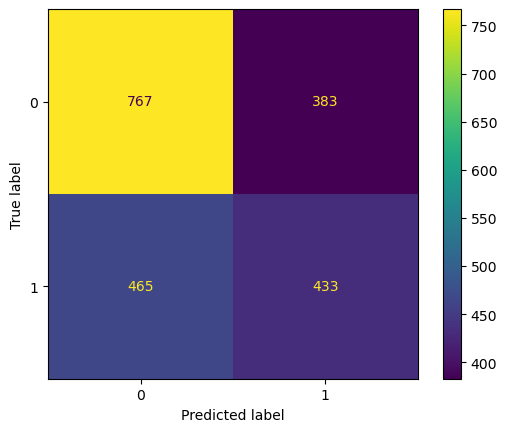

In [43]:
from sklearn.svm import LinearSVC
linear_svm_classifier = LinearSVC(C=1.0, random_state=0)

get_evaluation_result(linear_svm_classifier, X_train, X_test, y_train, y_test)

# 14. SDGClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60498046875
Precision: 0.5607094133697135
Recall: 0.4576837416481069
F1 Score: 0.5039852851011649
Matthews Correlation Coefficient: 0.1839161706126169
Cohen's Kappa: 0.1813343083871095
AUC-ROC: 0.5888418708240535
classification_report: 
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1150
           1       0.56      0.46      0.50       898

    accuracy                           0.60      2048
   macro avg       0.60      0.59      0.59      2048
weighted avg       0.60      0.60      0.60      2048



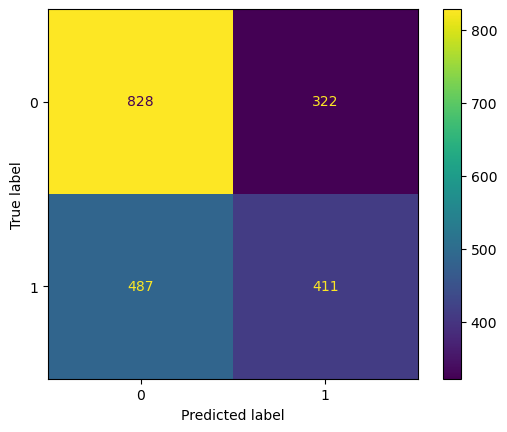

In [44]:
from sklearn.linear_model import SGDClassifier
# Create an SGDClassifier instance with hinge loss (SVM-like behavior), L2 regularization, and an initial learning rate (eta0)
sgd_classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, eta0=0.01, random_state=0, max_iter=1000)

get_evaluation_result(sgd_classifier, X_train, X_test, y_train, y_test)

# 15. ZeroR

C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: 

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5615234375
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Cohen's Kappa: 0.0
AUC-ROC: 0.5
classification_report: 
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1150
           1       0.00      0.00      0.00       898

    accuracy                           0.56      2048
   macro avg       0.28      0.50      0.36      2048
weighted avg       0.32      0.56      0.40      2048



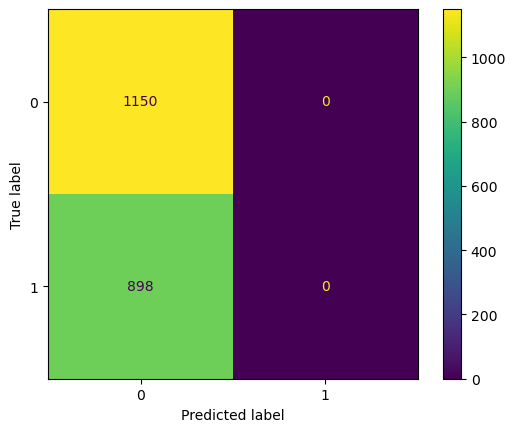

In [45]:
from sklearn.dummy import DummyClassifier

# Create a ZeroR classifier
zeror_model = DummyClassifier(strategy="most_frequent")

get_evaluation_result(zeror_model, X_train, X_test, y_train, y_test)



# 16. DecisionTreeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5556640625
Precision: 0.49363057324840764
Recall: 0.5178173719376392
F1 Score: 0.5054347826086957
Matthews Correlation Coefficient: 0.10258121794264287
Cohen's Kappa: 0.10248457973270253
AUC-ROC: 0.5515173816209935
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1150
           1       0.49      0.52      0.51       898

    accuracy                           0.56      2048
   macro avg       0.55      0.55      0.55      2048
weighted avg       0.56      0.56      0.56      2048



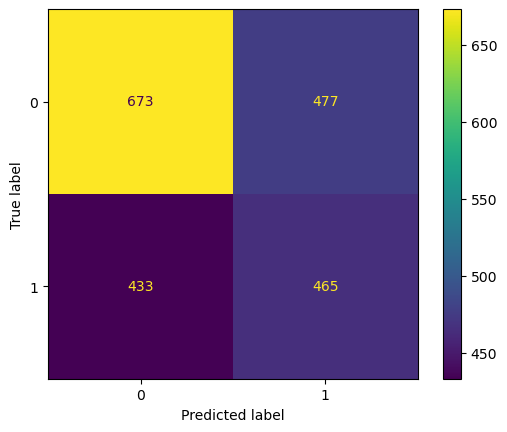

In [46]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=0)

get_evaluation_result(dt_classifier, X_train, X_test, y_train, y_test)

# 17.Passive Aggressive (PassiveAggressiveClassifier)

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.55615234375
Precision: 0.49392265193370166
Recall: 0.4977728285077951
F1 Score: 0.49584026622296173
Matthews Correlation Coefficient: 0.09942943219768983
Cohen's Kappa: 0.09942704110559197
AUC-ROC: 0.5497559794712888
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1150
           1       0.49      0.50      0.50       898

    accuracy                           0.56      2048
   macro avg       0.55      0.55      0.55      2048
weighted avg       0.56      0.56      0.56      2048



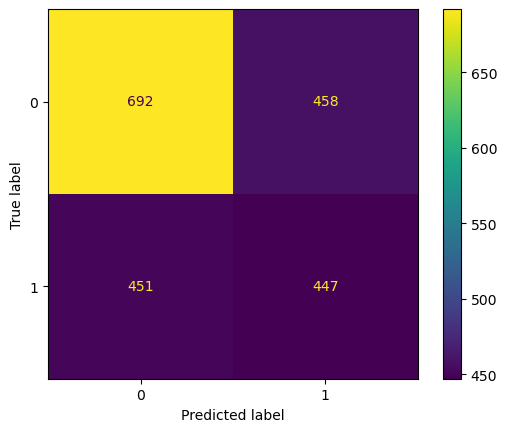

In [47]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa_classifier = PassiveAggressiveClassifier(C=1.0, random_state=0, max_iter=1000)

get_evaluation_result(pa_classifier, X_train, X_test, y_train, y_test)

# 18.ExtraTreeClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.58251953125
Precision: 0.5354200988467874
Recall: 0.3619153674832962
F1 Score: 0.4318936877076412
Matthews Correlation Coefficient: 0.12680140829383005
Cohen's Kappa: 0.120993861655325
AUC-ROC: 0.5583489880894742
classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1150
           1       0.54      0.36      0.43       898

    accuracy                           0.58      2048
   macro avg       0.57      0.56      0.55      2048
weighted avg       0.57      0.58      0.57      2048



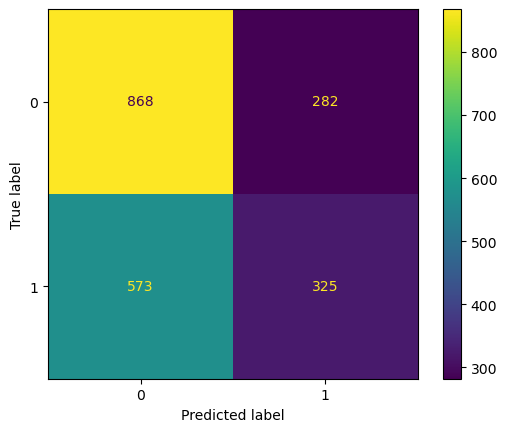

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_classifier = ExtraTreesClassifier(n_estimators=100, random_state=0)

get_evaluation_result(extra_tree_classifier, X_train, X_test, y_train, y_test)

# 19.Random Patches

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.56982421875
Precision: 0.5149911816578483
Recall: 0.32516703786191536
F1 Score: 0.3986348122866894
Matthews Correlation Coefficient: 0.09541162331703609
Cohen's Kappa: 0.08965745504009104
AUC-ROC: 0.5430183015396534
classification_report: 
              precision    recall  f1-score   support

           0       0.59      0.76      0.67      1150
           1       0.51      0.33      0.40       898

    accuracy                           0.57      2048
   macro avg       0.55      0.54      0.53      2048
weighted avg       0.56      0.57      0.55      2048



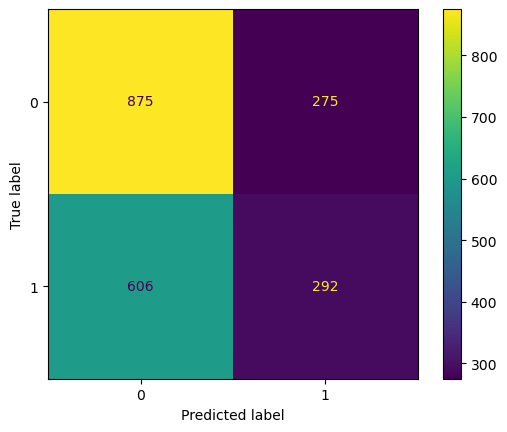

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a base learner (e.g., Decision Tree)
base_learner = DecisionTreeClassifier()

# Create a BaggingClassifier with Random Patches
bagging = BaggingClassifier(base_learner, max_samples=0.8, max_features=0.8, n_estimators=10, random_state=42)

get_evaluation_result(bagging, X_train, X_test, y_train, y_test)

# 20.VotingClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5498046875
Precision: 0.48660714285714285
Recall: 0.48552338530066813
F1 Score: 0.4860646599777035
Matthews Correlation Coefficient: 0.08554442815679605
Cohen's Kappa: 0.08554425985618641
AUC-ROC: 0.542761692650334
classification_report: 
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1150
           1       0.49      0.49      0.49       898

    accuracy                           0.55      2048
   macro avg       0.54      0.54      0.54      2048
weighted avg       0.55      0.55      0.55      2048



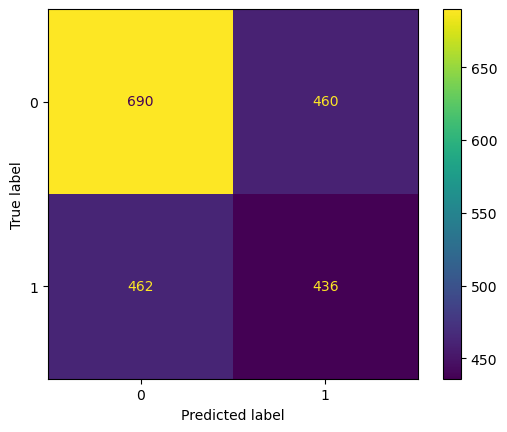

In [50]:
from sklearn.ensemble import VotingClassifier

# Define individual classifiers
classifier1 = DecisionTreeClassifier()
classifier2 = SVC(probability=True)  # Use probability=True for soft voting
classifier3 = RandomForestClassifier()

# Create a VotingClassifier instance with soft voting
voting_classifier = VotingClassifier(estimators=[
    ('decision_tree', classifier1),
    ('svm', classifier2),
    ('random_forest', classifier3)
], voting='soft')  # You can also use 'hard' for hard voting

get_evaluation_result(voting_classifier, X_train, X_test, y_train, y_test)

# 21. Stacked_generalization

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.6123046875
Precision: 0.5878378378378378
Recall: 0.38752783964365256
F1 Score: 0.4671140939597315
Matthews Correlation Coefficient: 0.19193803436880907
Cohen's Kappa: 0.1821546979109666
AUC-ROC: 0.5876769633000871
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      1150
           1       0.59      0.39      0.47       898

    accuracy                           0.61      2048
   macro avg       0.61      0.59      0.58      2048
weighted avg       0.61      0.61      0.60      2048



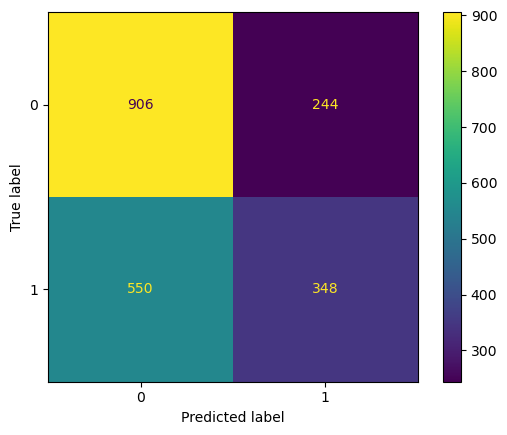

In [51]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('svc', SVC(probability=True)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create a StackingClassifier instance
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

get_evaluation_result(stacked_model, X_train, X_test, y_train, y_test)

# 22.MLPClassifier:

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.55712890625
Precision: 0.49504950495049505
Recall: 0.5011135857461024
F1 Score: 0.4980630879911455
Matthews Correlation Coefficient: 0.10185250415069887
Cohen's Kappa: 0.10184646151287224
AUC-ROC: 0.5509915754817469
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1150
           1       0.50      0.50      0.50       898

    accuracy                           0.56      2048
   macro avg       0.55      0.55      0.55      2048
weighted avg       0.56      0.56      0.56      2048



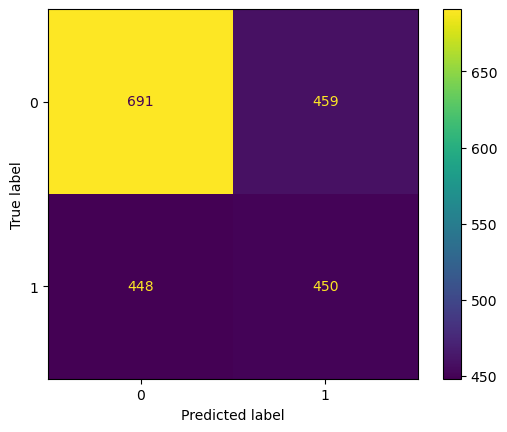

In [52]:
from sklearn.neural_network import MLPClassifier

# Create an MLPClassifier instance with specified architecture and hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=0)

get_evaluation_result(mlp_classifier, X_train, X_test, y_train, y_test)

# 23.BernoulliRBM:

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5947265625
Precision: 0.5553745928338762
Recall: 0.37973273942093544
F1 Score: 0.4510582010582011
Matthews Correlation Coefficient: 0.15415572827004925
Cohen's Kappa: 0.1474507380762271
AUC-ROC: 0.5711707175365547
classification_report: 
              precision    recall  f1-score   support

           0       0.61      0.76      0.68      1150
           1       0.56      0.38      0.45       898

    accuracy                           0.59      2048
   macro avg       0.58      0.57      0.56      2048
weighted avg       0.59      0.59      0.58      2048



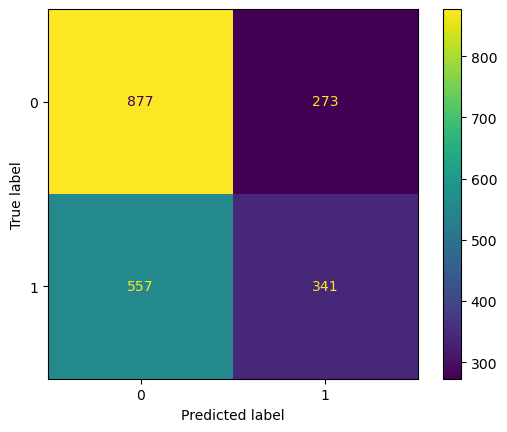

In [53]:
import lightgbm as lgb
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

get_evaluation_result(lgb_classifier, X_train, X_test, y_train, y_test)

# 24.AdaBoostClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5908203125
Precision: 0.5877192982456141
Recall: 0.22383073496659242
F1 Score: 0.3241935483870968
Matthews Correlation Coefficient: 0.13466650990252027
Cohen's Kappa: 0.1085884293674505
AUC-ROC: 0.5506110196572093
classification_report: 
              precision    recall  f1-score   support

           0       0.59      0.88      0.71      1150
           1       0.59      0.22      0.32       898

    accuracy                           0.59      2048
   macro avg       0.59      0.55      0.52      2048
weighted avg       0.59      0.59      0.54      2048



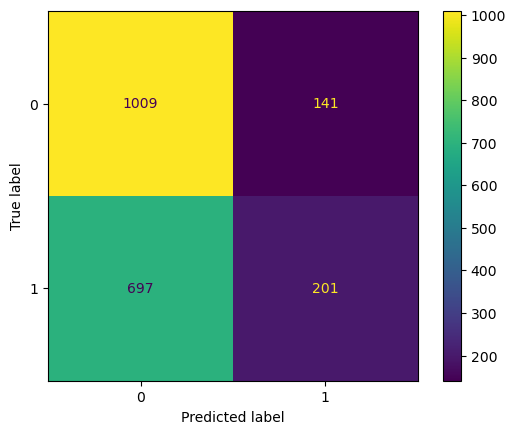

In [54]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)

get_evaluation_result(adaboost_classifier, X_train, X_test, y_train, y_test)

# 25.GradientBoostingClassifier

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.59423828125
Precision: 0.5943661971830986
Recall: 0.23496659242761692
F1 Score: 0.33679169992019153
Matthews Correlation Coefficient: 0.14386190291440532
Cohen's Kappa: 0.11753615643556548
AUC-ROC: 0.5548746005616345
classification_report: 
              precision    recall  f1-score   support

           0       0.59      0.87      0.71      1150
           1       0.59      0.23      0.34       898

    accuracy                           0.59      2048
   macro avg       0.59      0.55      0.52      2048
weighted avg       0.59      0.59      0.55      2048



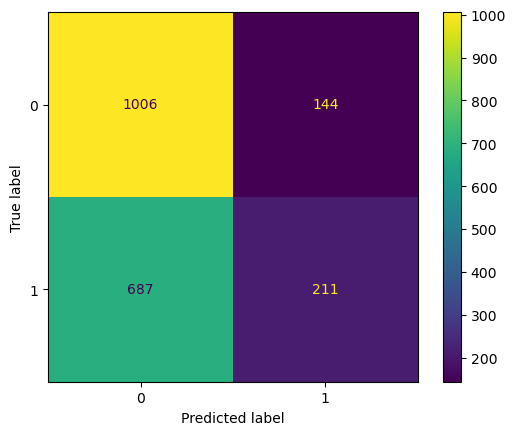

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

get_evaluation_result(gb_classifier, X_train, X_test, y_train, y_test)

# 26.Ordinal Learning Model

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.6083984375
Precision: 0.5757097791798107
Recall: 0.4064587973273942
F1 Score: 0.4765013054830287
Matthews Correlation Coefficient: 0.18519191863679682
Cohen's Kappa: 0.17828855474487615
AUC-ROC: 0.5862728769245668
classification_report: 
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1150
           1       0.58      0.41      0.48       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.59      2048



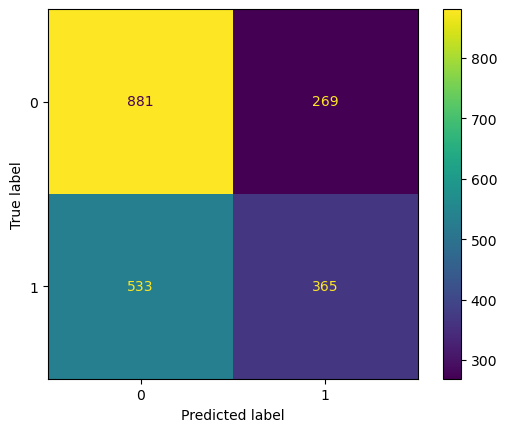

In [56]:
from mord import LogisticAT

# Create and train an Ordinal Logistic Regression model (LogisticAT)
ordinal_classifier = LogisticAT(alpha=1.0)  # You can adjust the regularization parameter alpha

get_evaluation_result(ordinal_classifier, X_train, X_test, y_train, y_test)

# 27.Xgboost

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.59423828125
Precision: 0.5943661971830986
Recall: 0.23496659242761692
F1 Score: 0.33679169992019153
Matthews Correlation Coefficient: 0.14386190291440532
Cohen's Kappa: 0.11753615643556548
AUC-ROC: 0.5548746005616345
classification_report: 
              precision    recall  f1-score   support

           0       0.59      0.87      0.71      1150
           1       0.59      0.23      0.34       898

    accuracy                           0.59      2048
   macro avg       0.59      0.55      0.52      2048
weighted avg       0.59      0.59      0.55      2048



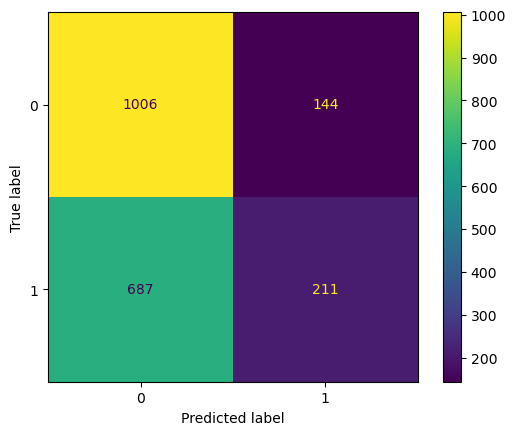

In [57]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create an XGBClassifier instance with specified hyperparameters
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

get_evaluation_result(xgb_classifier, X_train, X_test, y_train, y_test)

# 28.Decision Stump

C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: 

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5615234375
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Cohen's Kappa: 0.0
AUC-ROC: 0.5
classification_report: 
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1150
           1       0.00      0.00      0.00       898

    accuracy                           0.56      2048
   macro avg       0.28      0.50      0.36      2048
weighted avg       0.32      0.56      0.40      2048



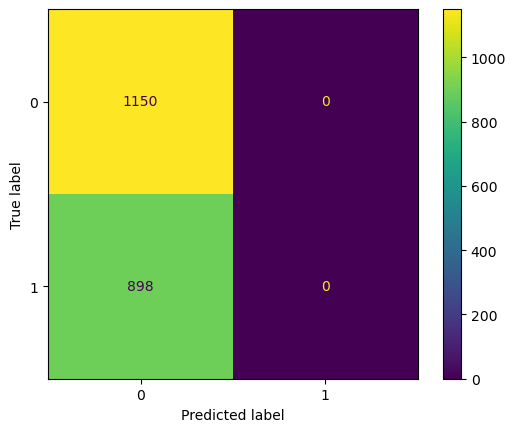

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a Decision Stump (a DecisionTreeClassifier with max_depth=1)
decision_stump = DecisionTreeClassifier(max_depth=1)

get_evaluation_result(decision_stump, X_train, X_test, y_train, y_test)

# 29.ComplementNB

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.60693359375
Precision: 0.568685376661743
Recall: 0.4287305122494432
F1 Score: 0.48888888888888893
Matthews Correlation Coefficient: 0.18439912437131437
Cohen's Kappa: 0.17966192103529466
AUC-ROC: 0.5874087343855913
classification_report: 
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1150
           1       0.57      0.43      0.49       898

    accuracy                           0.61      2048
   macro avg       0.60      0.59      0.58      2048
weighted avg       0.60      0.61      0.60      2048



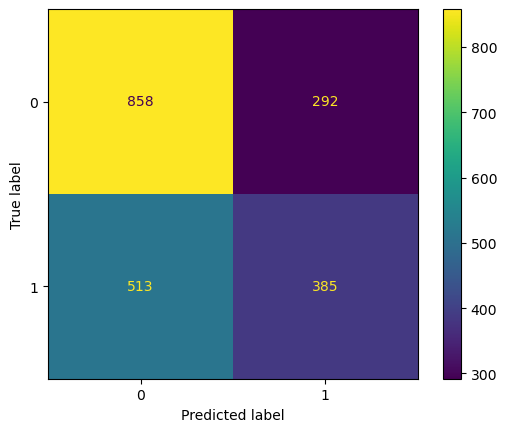

In [59]:
from sklearn.naive_bayes import ComplementNB

# Create a ComplementNB instance
complement_nb_classifier = ComplementNB()
get_evaluation_result(complement_nb_classifier, X_train, X_test, y_train, y_test)

# 30.MultinomialNB

Accuracy of Logistic classifier on training set: 1.00
Accuracy of Logistic classifier on test set: 0.57
Accuracy: 0.5947265625
Precision: 0.5994152046783626
Recall: 0.22828507795100222
F1 Score: 0.33064516129032256
Matthews Correlation Coefficient: 0.14522010161722435
Cohen's Kappa: 0.11709832502981377
AUC-ROC: 0.5545773215841968
classification_report: 
              precision    recall  f1-score   support

           0       0.59      0.88      0.71      1150
           1       0.60      0.23      0.33       898

    accuracy                           0.59      2048
   macro avg       0.60      0.55      0.52      2048
weighted avg       0.60      0.59      0.54      2048



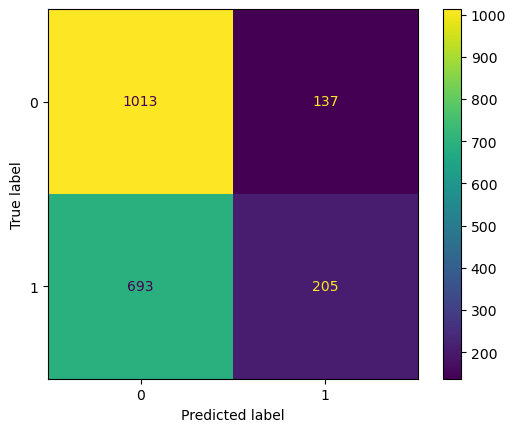

In [60]:
from sklearn.naive_bayes import MultinomialNB

# Create a MultinomialNB instance
multinomial_nb_classifier = MultinomialNB()
get_evaluation_result(multinomial_nb_classifier, X_train, X_test, y_train, y_test)